## Outreach for each post

I successivi blocchi di codice consentono di fare un confronto tra la len dell'interazione e la size dell'outreach di una pagina misurata come Lurkers in quel momento.

In [6]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv',usecols=['created_time', 'page_id', 'post_id'],encoding='ISO-8859-1')
likes = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_likes.csv', usecols=['from_id', 'post_id'], encoding='ISO-8859-1')
np.mean(posts['post_id'].isin(likes['post_id'])) # Solo del 66% dei post abbiamo i like? questa cosa è strana e da ricontrollare.

np.float64(0.6627619477450383)

Salvo per ciascuna pagine la serie storica dei Lurkers, ovvero il numero di utenti univoci che ha lasciato like a un qualsiasi post della pagina.

In [5]:
folder_path = '/home/jacoponudo/Documents/Size_effects/DATA/'
dataframes = []

# Itera su ogni ID di pagina unico
for page_id in tqdm(posts['page_id'].unique()):
    page_posts = posts[posts['page_id'] == page_id]
    page_likes = likes[likes['post_id'].isin(page_posts['post_id'].unique())]

    # Unisci i dati dei post con i dati dei like
    complete_page_likes = pd.merge(page_posts, page_likes, on='post_id', how='right')
    complete_page_likes['created_time'] = pd.to_datetime(complete_page_likes['created_time'])
    complete_page_likes.set_index('created_time', inplace=True)

    # Calcola il numero di utenti unici settimanali
    weekly_unique_users = complete_page_likes['from_id'].resample('W').nunique()
    monthly_moving_avg = weekly_unique_users.rolling(window=8).mean()
    
    # Crea il DataFrame per la media mobile mensile
    monthly_avg_df = pd.DataFrame({
        'Date': monthly_moving_avg.index,
        'Monthly Moving Average': monthly_moving_avg.values
    }).dropna() 
    
    # Aggiungi l'ID della pagina
    monthly_avg_df.insert(2, 'page_id', page_id)
    dataframes.append(monthly_avg_df)

# Concatenazione di tutti i DataFrame in un unico DataFrame outreach
outreachs = pd.concat(dataframes, ignore_index=True)

# Salva il file completo di outreach
output_file = f'{folder_path}/sample_outreachs.csv'
outreachs.to_csv(output_file, index=False)

print(f"File salvato in: {output_file}")

100%|██████████| 117/117 [08:48<00:00,  4.51s/it]

File salvato in: /home/jacoponudo/Documents/Size_effects/DATA//sample_outreachs.csv


Puliamo la ram da tutti i file in memoria.

In [12]:
import gc
def clear_all():
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()

# Pulisci la RAM da tutte le variabili
clear_all()

Per ogni interazione, calcolo quanto dura (interaction len) e dove avviene (page_id), e qual'era il valore di Luckers sulla pagina su cui avviene in quel momento.

In [7]:
comments = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_comments.csv',encoding='ISO-8859-1',usecols=['from_id', 'post_id'])
interactions = comments.groupby(['from_id', 'post_id']).size().reset_index(name='interaction_len')
del comments
gc.collect()

0

Interpolazione dell'outreach di ogni post.

In [8]:
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv',usecols=['created_time', 'page_id', 'post_id'],encoding='ISO-8859-1')
outreach_values = []
for idx, post in tqdm(posts.iterrows(), total=posts.shape[0]):
    page_id = post['page_id']
    outreach = outreachs[outreachs['page_id'] == int(page_id)].copy()
    target_date = pd.to_datetime(post['created_time'])
    previous_date_row = outreach[outreach['Date'] < target_date]
    if not previous_date_row.empty:
        monthly_moving_avg = previous_date_row.loc[previous_date_row['Date'].idxmax()]['Monthly Moving Average']
    else:
        monthly_moving_avg = None
    outreach_values.append(monthly_moving_avg)
posts['outreach'] = outreach_values


100%|██████████| 1482309/1482309 [24:08<00:00, 1023.59it/s]


In [11]:
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions['interaction_len'] < 2)
posts_selected = posts[['post_id', 'outreach']]
merged_df = pd.merge(interactions_selected, posts_selected, on='post_id', how='inner')
merged_df.to_csv('/home/jacoponudo/Documents/Size_effects/DATA/facebook_outreach_vs_interaction.csv')

---

## Alpha vs Year

In [12]:
import pandas as pd
posts['created_time'] = pd.to_datetime(posts['created_time'])
posts['year'] = posts['created_time'].dt.year
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions_selected['interaction_len'] < 2).astype(int)
posts_selected = posts[['post_id', 'outreach', 'created_time', 'year']]
merged = pd.merge(posts_selected, interactions_selected, on='post_id', how='left')
alpha_mean_per_year = merged.groupby('year')['alpha'].mean().reset_index()
print(alpha_mean_per_year)


   year     alpha
0  2009  0.982904
1  2010  0.909769
2  2011  0.904988
3  2012  0.901978
4  2013  0.926843
5  2014  0.378511
6  2015  0.960698
7  2016  1.000000


## Interaction len VS outreach

<Figure size 1200x600 with 0 Axes>

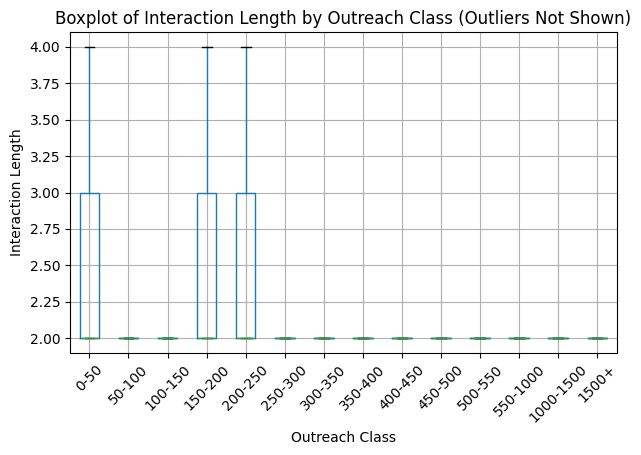

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Merge data
merged_df = pd.merge(interactions_selected[interactions_selected['interaction_len'] >= 2], posts_selected, on='post_id', how='inner')
merged_df = merged_df[merged_df['outreach'] < 3000]

# Prepare data
x = merged_df['outreach']
y = merged_df['interaction_len']

# Define the bin edges and labels
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 1000, 1500, np.inf]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450', '450-500', '500-550', '550-1000', '1000-1500', '1500+']

# Cut x into classes
merged_df['outreach_class'] = pd.cut(x, bins=bins, labels=labels, right=False)

# Create boxplot without showing outliers
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='interaction_len', by='outreach_class', showfliers=False, grid=False)

# Customize the plot
plt.title('Boxplot of Interaction Length by Outreach Class (Outliers Not Shown)')
plt.suptitle('')  # Remove the default title added by boxplot
plt.xlabel('Outreach Class')
plt.ylabel('Interaction Length')
# plt.yscale('log')  # Uncomment to set y-axis to log scale
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout
plt.show()


## Alpha vs Page

              page_id     alpha
0          5953112932  1.000000
1          6250307292  0.958421
2          6533373917  0.966717
3          7130088677  0.972269
4          7155422274  0.965182
..                ...       ...
109   527351247377965  0.971910
110   552321618120006  1.000000
111   554092937948891  1.000000
112   842786335748518  0.933333
113  1512926715599838  0.967302

[114 rows x 2 columns]


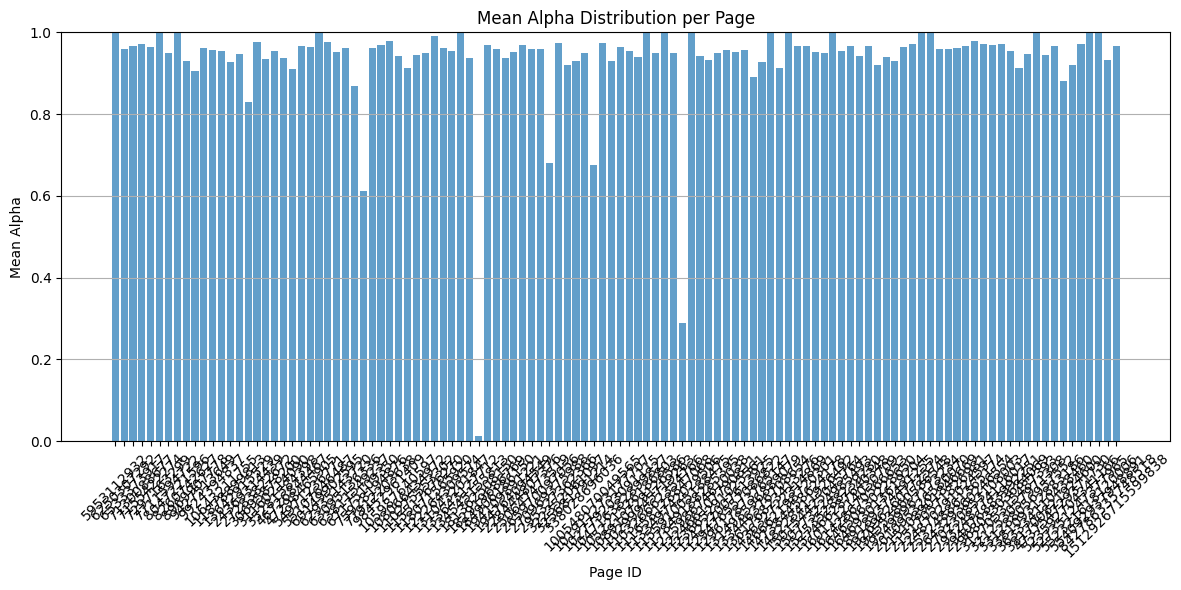

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Seleziona le colonne desiderate da interactions e crea la colonna 'alpha'
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions['interaction_len'] == 1).astype(int)  # Convert to int (0 or 1)

# Seleziona le colonne desiderate da posts
posts_selected = posts[['post_id', 'outreach', 'created_time', 'page_id']]

# Unisci i due DataFrame
merged_df = pd.merge(interactions_selected, posts_selected, on='post_id', how='inner')

# Raggruppa per 'alpha' e 'page_id' e calcola la media di 'alpha'
result = merged_df.groupby('page_id')['alpha'].mean().reset_index()

# Visualizza il risultato
print(result)

# Plot della distribuzione di alpha per pagina
plt.figure(figsize=(12, 6))
plt.bar(result['page_id'].astype(str), result['alpha'], alpha=0.7)  # Use a colormap manually
plt.title('Mean Alpha Distribution per Page')
plt.xlabel('Page ID')
plt.ylabel('Mean Alpha')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.grid(axis='y')

# Mostra il grafico
plt.tight_layout()
plt.show()


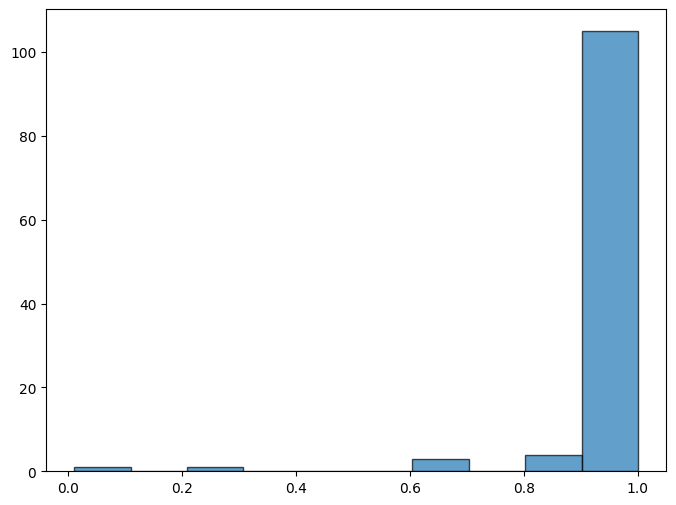

In [21]:
import matplotlib.pyplot as plt

# Crea l'istogramma della distribuzione di alpha
plt.figure(figsize=(8, 6))
plt.hist(result['alpha'], edgecolor='black', alpha=0.7)

# Aggiungi titolo e etichette
plt.show()


## Alpha VS outreach

/tmp/ipykernel_27688/2685169305.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outreach_alpha_mean = merged_df.groupby('outreach_class')['alpha'].mean()


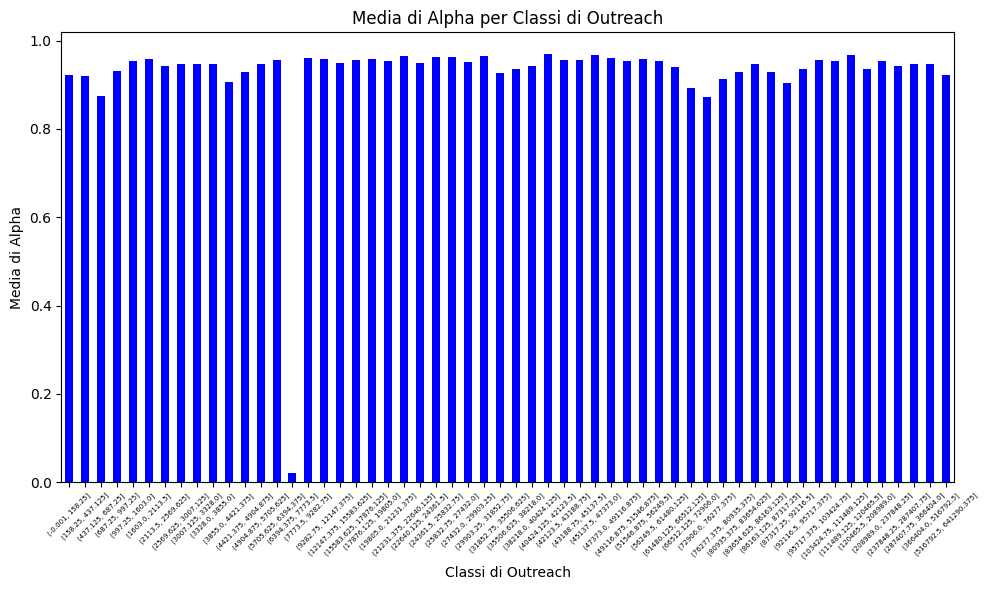

In [7]:

merged_df=pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/interacions/facebook_outreach_vs_interaction.csv')
merged_df['outreach_class'] = pd.qcut(merged_df['outreach'], q=100, duplicates='drop')
outreach_alpha_mean = merged_df.groupby('outreach_class')['alpha'].mean()
plt.figure(figsize=(10, 6))
outreach_alpha_mean.plot(kind='bar', color='blue')
plt.title('Media di Alpha per Classi di Outreach')
plt.xlabel('Classi di Outreach')
plt.ylabel('Media di Alpha')
plt.xticks(rotation=45,fontsize=5)
plt.tight_layout()
plt.show()


# Analisi delle interazioni

In [16]:
import pandas as pd

interactions = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/interacions/facebook_outreach_vs_interaction.csv',nrows=5,usecols=['post_id', 'alpha', 'outreach'])
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv', usecols=['created_time', 'page_id', 'post_id'], encoding='ISO-8859-1')


interactions = pd.merge(interactions, posts, on='post_id', how='left')

print(interactions.head())


                           post_id  alpha   outreach  \
0      10643211755_222971191182319   True        NaN   
1    35281584398_10151655784439399   True   1350.125   
2     6250307292_10150964198672293   True        NaN   
3  113349742029506_644708212226987   True      6.500   
4     7155422274_10153792989482275   True  44599.625   

               created_time          page_id  
0  2013-03-07T18:00:01+0000      10643211755  
1  2013-06-10T16:04:00+0000      35281584398  
2  2012-07-24T23:34:59+0000       6250307292  
3  2013-09-30T06:45:27+0000  113349742029506  
4  2015-10-07T19:44:42+0000       7155422274  


In [18]:
import pandas as pd

# Carica i dati
interactions = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/interacions/facebook_outreach_vs_interaction.csv', usecols=['post_id', 'alpha', 'outreach'])
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv', usecols=['created_time', 'page_id', 'post_id'], encoding='ISO-8859-1')

# Crea un dizionario da 'posts' usando 'post_id' come chiave
posts_dict = posts.set_index('post_id').T.to_dict()

# Aggiungi le colonne 'created_time' e 'page_id' a 'interactions'
interactions['created_time'] = interactions['post_id'].map(lambda x: posts_dict.get(x, {}).get('created_time', None))
interactions['page_id'] = interactions['post_id'].map(lambda x: posts_dict.get(x, {}).get('page_id', None))

# Visualizza i primi risultati
print(interactions.head())


/tmp/ipykernel_27688/1848857759.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  posts_dict = posts.set_index('post_id').T.to_dict()


                           post_id  alpha   outreach  \
0      10643211755_222971191182319   True        NaN   
1    35281584398_10151655784439399   True   1350.125   
2     6250307292_10150964198672293   True        NaN   
3  113349742029506_644708212226987   True      6.500   
4     7155422274_10153792989482275   True  44599.625   

               created_time          page_id  
0  2013-03-07T18:00:01+0000      10643211755  
1  2013-06-10T16:04:00+0000      35281584398  
2  2012-07-24T23:34:59+0000       6250307292  
3  2013-09-30T06:45:27+0000  113349742029506  
4  2015-10-07T19:44:42+0000       7155422274  


In [21]:
interactions=interactions.dropna()


,post_id,alpha,outreach,created_time,page_id
1,35281584398_10151655784439399,True,1350.125,2013-06-10T16:04:00+0000,35281584398
3,113349742029506_644708212226987,True,6.500,2013-09-30T06:45:27+0000,113349742029506
4,7155422274_10153792989482275,True,44599.625,2015-10-07T19:44:42+0000,7155422274
8,67175109350_205981829418171,True,43.125,2011-03-01T17:33:52+0000,67175109350
11,7155422274_10151218230287275,True,15919.625,2012-08-24T08:15:30+0000,7155422274
...,...,...,...,...,...
51005989,63811549237_10153818909829238,True,503045.750,2015-10-04T02:30:00+0000,63811549237
51005990,63811549237_10151895990989238,True,68981.000,2013-09-07T14:20:00+0000,63811549237
51005991,63811549237_10151901777024238,True,63119.250,2013-09-10T00:48:39+0000,63811549237
51005992,63811549237_10151903069119238,True,63119.250,2013-09-10T15:20:46+0000,63811549237


In [36]:
interactions['page_id'].sample(10)

32595219    181362508150
29559386     63811549237
20646142    182919686769
46194575    181362508150
16123670    182919686769
12262700     10643211755
24680389    181362508150
25874401    182919686769
41386262     63811549237
791163       47298465905
Name: page_id, dtype: int64

/tmp/ipykernel_27688/2023966278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['created_time'] = pd.to_datetime(page_interactions['created_time'])
/tmp/ipykernel_27688/2023966278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['year'] = page_interactions['created_time'].dt.year


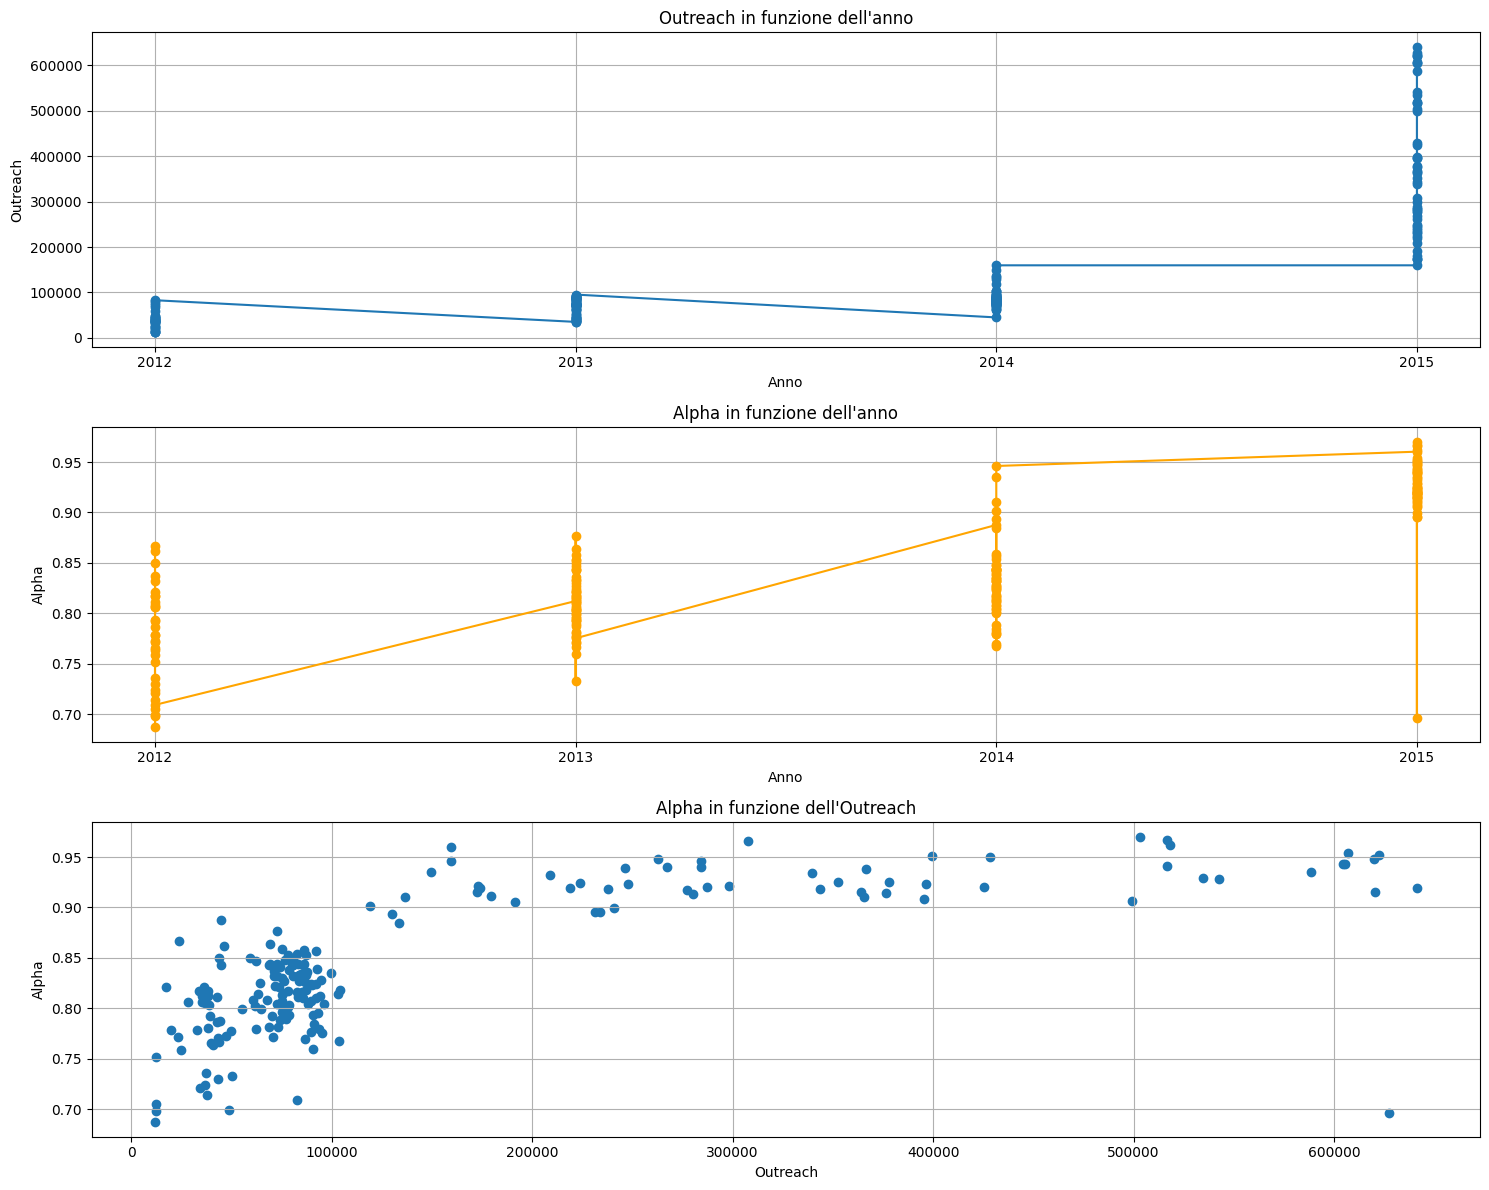

In [38]:
page_interactions=interactions[interactions['page_id']==63811549237]

# Supponendo che 'page_interactions' sia già definito
# Calcolo della media di alpha per anno e outreach
page_interactions['created_time'] = pd.to_datetime(page_interactions['created_time'])
page_interactions['year'] = page_interactions['created_time'].dt.year

alpha_year_outreach = page_interactions.groupby(['year', 'outreach'])['alpha'].mean().reset_index()

# Plot di outreach in funzione dell'anno
plt.figure(figsize=(15, 12))

# Sottoplot 1: Outreach in funzione dell'anno
plt.subplot(3, 1, 1)
plt.plot(alpha_year_outreach['year'], alpha_year_outreach['outreach'], marker='o')
plt.title('Outreach in funzione dell\'anno')
plt.xlabel('Anno')
plt.ylabel('Outreach')
plt.grid()
plt.xticks(alpha_year_outreach['year'].unique())  # Mostra solo gli anni unici sull'asse x

# Sottoplot 2: Alpha in funzione dell'anno
plt.subplot(3, 1, 2)
plt.plot(alpha_year_outreach['year'], alpha_year_outreach['alpha'], marker='o', color='orange')
plt.title('Alpha in funzione dell\'anno')
plt.xlabel('Anno')
plt.ylabel('Alpha')
plt.grid()
plt.xticks(alpha_year_outreach['year'].unique())  # Mostra solo gli anni unici sull'asse x

# Sottoplot 3: Alpha in funzione dell'outreach
plt.subplot(3, 1, 3)
plt.scatter(alpha_year_outreach['outreach'], alpha_year_outreach['alpha'])
plt.title('Alpha in funzione dell\'Outreach')
plt.xlabel('Outreach')
plt.ylabel('Alpha')
plt.grid()

plt.tight_layout()  # Per evitare sovrapposizioni nei sottoplot
plt.show()


Index(['year', 'outreach', 'alpha', 'lower', 'upper', 'alpha_smooth'], dtype='object')


/home/jacoponudo/.local/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in scalar divide
  return std / np.sqrt(self.sum_weights - 1)
/tmp/ipykernel_27688/2198207109.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=alpha_year_outreach, x='outreach', y='alpha_smooth', ci=None, color='b')


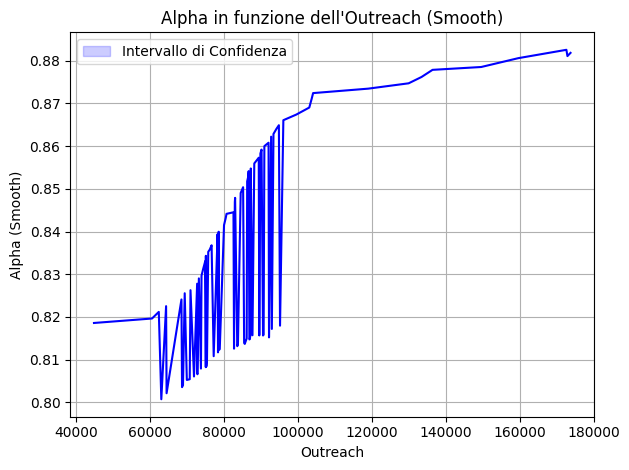

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Supponiamo che alpha_year_outreach sia già definito e contenga 'outreach' e 'alpha'
# Controlla le colonne
print(alpha_year_outreach.columns)

# Calcola gli intervalli di confidenza per alpha
alpha_year_outreach['lower'] = np.nan
alpha_year_outreach['upper'] = np.nan

for index, row in alpha_year_outreach.iterrows():
    conf_int = sm.stats.DescrStatsW([row['alpha']]).tconfint_mean()
    alpha_year_outreach.at[index, 'lower'] = conf_int[0]
    alpha_year_outreach.at[index, 'upper'] = conf_int[1]

# Calcola una media mobile per rendere i dati più fluidi
alpha_year_outreach['alpha_smooth'] = alpha_year_outreach['alpha'].rolling(window=100, center=True).mean()


# Line plot senza intervallo di confidenza
sns.lineplot(data=alpha_year_outreach, x='outreach', y='alpha_smooth', ci=None, color='b')

# Calcola lo spessore per gli intervalli di confidenza
interval_width = alpha_year_outreach['upper'] - alpha_year_outreach['lower']
plt.fill_between(alpha_year_outreach['outreach'], alpha_year_outreach['lower'], alpha_year_outreach['upper'],
                 color='b', alpha=0.2, label='Intervallo di Confidenza')

plt.title('Alpha in funzione dell\'Outreach (Smooth)')
plt.xlabel('Outreach')
plt.ylabel('Alpha (Smooth)')
plt.grid()
plt.legend()

plt.tight_layout()  # Per evitare sovrapposizioni nei sottoplot
plt.show()


## Fare il confronto per il comportamento degli utenti per una stessa pagina al crescere della pagina